Import and deps

In [1]:
import subprocess
import pybedtools

Download GRCh38 reference genome

In [18]:
subprocess.run(['wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/GRCh38.primary_assembly.genome.fa.gz -O ../data/GRCh38.primary_assembly.genome.fa.gz'], shell=True)

--2023-06-29 09:45:12--  ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/GRCh38.primary_assembly.genome.fa.gz
           => ‘../data/GRCh38.primary_assembly.genome.fa.gz’
Resolving ftp.ebi.ac.uk (ftp.ebi.ac.uk)... 193.62.193.138
Connecting to ftp.ebi.ac.uk (ftp.ebi.ac.uk)|193.62.193.138|:21... connected.
Logging in as anonymous ... Logged in!
==> SYST ... done.    ==> PWD ... done.
==> TYPE I ... done.  ==> CWD (1) /pub/databases/gencode/Gencode_human/release_38 ... done.
==> SIZE GRCh38.primary_assembly.genome.fa.gz ... 844691642
==> PASV ... done.    ==> RETR GRCh38.primary_assembly.genome.fa.gz ... done.
Length: 844691642 (806M) (unauthoritative)

     0K .......... .......... .......... .......... ..........  0%  344K 39m57s
    50K .......... .......... .......... .......... ..........  0%  371K 38m30s
   100K .......... .......... .......... .......... ..........  0%  195M 25m41s
   150K .......... .......... .......... .......... ..........  0%  189M 19m17s
  

CompletedProcess(args=['wget ftp://ftp.ebi.ac.uk/pub/databases/gencode/Gencode_human/release_38/GRCh38.primary_assembly.genome.fa.gz -O ../data/GRCh38.primary_assembly.genome.fa.gz'], returncode=0)

In [20]:
subprocess.run(['gunzip ../data/GRCh38.primary_assembly.genome.fa.gz'], shell=True)

CompletedProcess(args=['gunzip ../data/GRCh38.primary_assembly.genome.fa.gz'], returncode=0)

In [21]:
subprocess.run(['wget https://ftp.ensembl.org/pub/release-109/variation/vcf/homo_sapiens/homo_sapiens_structural_variations.vcf.gz -O ../data/homo_sapiens_structural_variations.vcf'], shell=True)

--2023-06-29 10:21:27--  https://ftp.ensembl.org/pub/release-109/variation/vcf/homo_sapiens/homo_sapiens_structural_variations.vcf.gz
Resolving ftp.ensembl.org (ftp.ensembl.org)... 193.62.193.139
Connecting to ftp.ensembl.org (ftp.ensembl.org)|193.62.193.139|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 267618924 (255M) [application/x-gzip]
Saving to: ‘homo_sapiens_structural_variations.vcf.gz’

     0K .......... .......... .......... .......... ..........  0%  393K 11m5s
    50K .......... .......... .......... .......... ..........  0%  752K 8m26s
   100K .......... .......... .......... .......... ..........  0% 14.0M 5m43s
   150K .......... .......... .......... .......... ..........  0%  759K 5m44s
   200K .......... .......... .......... .......... ..........  0%  700K 5m49s
   250K .......... .......... .......... .......... ..........  0%  725K 5m51s
   300K .......... .......... .......... .......... ..........  0%  657K 5m58s
   350K .......... .

CompletedProcess(args=['wget https://ftp.ensembl.org/pub/release-109/variation/vcf/homo_sapiens/homo_sapiens_structural_variations.vcf.gz'], returncode=0)

In [23]:
subprocess.run(['gunzip ../data/homo_sapiens_structural_variations.vcf.gz'], shell=True)

CompletedProcess(args=['gunzip ../data/homo_sapiens_structural_variations.vcf.gz'], returncode=0)

In [6]:
brca1_coordinates = pybedtools.create_interval_from_list(["chr17", "43044295", "43125482"])
brca2_coordinates = pybedtools.create_interval_from_list(["chr13", "32315474", "32400266"])
regions = [brca1_coordinates, brca2_coordinates]
pybedtools.BedTool(regions).saveas("../data/BRCA1_BRCA2_regions.bed")

<BedTool(../data/BRCA1_BRCA2_regions.bed)>

In [34]:
reference_genome = "../data/GRCh38.primary_assembly.genome.fa"
targeted_reference_genome = "../data/targeted.fasta"
output_dict = "../data/GRCh38.primary_assembly.genome.dict"
input_bam = "../data/input_reads.bam"
targeted_input_bam = "../data/targeted_input_reads.bam"
targeted_input_sam = "../data/targeted_input_reads.sam"
output_sam = "../data/aligned_reads.sam"
sorted_bam = "../data/sorted_reads.bam"
filtered_bam = "../data/filtered_reads.bam"
output_vcf = "../data/output.vcf"
dbsnp_vcf = "../data/homo_sapiens_structural_variations.vcf"

In [12]:
subprocess.run([f"bedtools getfasta -fi {reference_genome} -bed ../data/BRCA1_BRCA2_regions.bed -fo {targeted_reference_genome}"], shell=True)

CompletedProcess(args=['bedtools getfasta -fi ../data/GRCh38.primary_assembly.genome.fa -bed ../data/BRCA1_BRCA2_regions.bed -fo ../data/targeted.fasta'], returncode=0)

In [8]:
subprocess.run([f"samtools faidx {targeted_reference_genome}"], shell=True)

CompletedProcess(args=['samtools faidx ../data/targeted.fasta'], returncode=0)

In [8]:
import subprocess
subprocess.run([f"samtools index {input_bam}"], shell=True)
subprocess.run([f"bedtools intersect -a {input_bam} -b ../data/BRCA1_BRCA2_regions.bed > {targeted_input_bam}"], shell=True)

CompletedProcess(args=['bedtools intersect -a ../data/input_reads.bam -b ../data/BRCA1_BRCA2_regions.bed > ../data/targeted_input_reads.bam'], returncode=0)

In [13]:
import pysam
bam_file = pysam.AlignmentFile(input_bam, 'rb')
bed_file = open('../data/BRCA1_BRCA2_regions.bed', 'r')
output_bam = pysam.AlignmentFile(targeted_input_bam, 'wb', header=bam_file.header)
regions = bed_file.readlines()
for region in regions:
    chrom, start, end = region.strip().split('\t')
    for alignment in bam_file.fetch(chrom, int(start), int(end)):
        output_bam.write(alignment)
        print(alignment)
bam_file.close()
output_bam.close()

HK9DR:01000:13801	16	#12	32333053	0	1S41M	*	0	0	GCAGGCGCCTGTAATCCCAGCTACTCGGGAGGCTGAGGCAGG	array('B', [9, 9, 11, 7, 10, 10, 20, 15, 25, 25, 28, 27, 23, 25, 25, 23, 32, 28, 27, 27, 25, 25, 24, 24, 24, 26, 19, 26, 26, 26, 22, 27, 27, 27, 25, 25, 22, 14, 14, 14, 20, 24])	[('ZP', array('f', [0.005853727459907532, 0.004401202313601971, 0.0008607461350038648])), ('ZE', 'CCTACACGACGCTCTTCCGATCTCAATTCT'), ('ZG', 268), ('ZB', 30), ('ZC', array('i', [268, 268, 2, 0])), ('ZA', 118), ('ZM', array('h', [254, -14, 272, -22, 8, 276, -32, 268, 228, -12, -34, 218, 272, 258, 230, 32, 22, 22, 494, 502, 12, 230, 462, 16, 242, 234, -26, 274, 32, 14, 6, -26, 286, -22, 494, 4, 216, 266, 266, 10, 16, 12, 24, -10, 270, 24, 260, 12, 22, 8, 256, 238, 28, 220, 118, -20, 42, 8, -12, 2, 274, 0, -16, 26, 264, 4, 240, 30, 484, -18, 498, 230, 12, 10, -10, -16, 234, -14, 10, 30, 270, 244, 0, 16, 276, 264, 6, 488, 460, -26, -60, 2, 276, 0, -30, 0, 270, -10, 424, 24, 224, 32, 58, 146, 68, 452, 186, -14, 70, 28, 310, 236,

In [14]:
import pysam
bam_file = pysam.AlignmentFile(targeted_input_bam, 'rb')
sam_file = pysam.AlignmentFile(targeted_input_sam, 'wh', header=bam_file.header)
for alignment in bam_file:
    sam_file.write(alignment)
bam_file.close()
sam_file.close()


[E::idx_find_and_load] Could not retrieve index file for '../data/targeted_input_reads.bam'


In [22]:
# import shlex
# num_threads = 4
# command = f"bwa mem -t {num_threads} -R '@RG\\tID:sampleID\\tSM:sampleID' {targeted_reference_genome} {targeted_input_bam}"
# args = shlex.split(command)
# with open(output_bam, "w") as output_file:
#     subprocess.call(args, stdout=output_file)

subprocess.call([f"bwa mem -t 4 -R '@RG\\tID:sampleID\\tSM:sampleID' {targeted_reference_genome} {targeted_input_bam} > {output_sam}"], shell=True)

[M::bwa_idx_load_from_disk] read 0 ALT contigs
[M::process] read 411 sequences (2328 bp)...
[M::mem_process_seqs] Processed 411 reads in 0.001 CPU sec, 0.001 real sec
[main] Version: 0.7.17-r1188
[main] CMD: bwa mem -t 4 -R @RG\tID:sampleID\tSM:sampleID ../data/targeted.fasta ../data/targeted_input_reads.bam
[main] Real time: 0.026 sec; CPU: 0.031 sec


0

In [23]:
# subprocess.call([f"samtools quickcheck {output_sam}"], shell=True)
# subprocess.call(["samtools", "view", "-bS", output_sam, "-o", sorted_bam])
subprocess.call([f"samtools view -bS {output_sam} > {sorted_bam}"], shell=True)
subprocess.call([f"samtools sort {sorted_bam} -o {sorted_bam}"], shell=True)

[W::sam_read1_sam] Parse error at line 415
samtools view: error reading file "../data/aligned_reads.sam"


0

In [27]:
subprocess.call([f"samtools index {sorted_bam}"], shell=True)

0

In [14]:
subprocess.call([f"samtools view -b {sorted_bam} chr17:43044295-43125482 > {filtered_bam}"], shell=True)
subprocess.run([f"samtools index {filtered_bam}"], shell=True)

CompletedProcess(args=['samtools index ../data/filtered_reads.bam'], returncode=0)

In [35]:
subprocess.call([f"gatk CreateSequenceDictionary -R {reference_genome} -O {output_dict}"], shell=True)

Using GATK jar /Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar CreateSequenceDictionary -R ../data/GRCh38.primary_assembly.genome.fa -O ../data/GRCh38.primary_assembly.genome.dict
14:48:36.006 INFO  NativeLibraryLoader - Loading libgkl_compression.dylib from jar:file:/Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.dylib
[Thu Jun 29 14:48:36 EEST 2023] CreateSequenceDictionary --OUTPUT ../data/GRCh38.primary_assembly.genome.dict --REFERENCE ../data/GRCh38.primary_assembly.genome.fa --TRUNCATE_NAMES_AT_WHITESPACE true --NUM_SEQUENCES 2147483647 --VERBOSITY INFO --QUIET false --V

Tool returned:
0


0

In [36]:
subprocess.call([f"gatk HaplotypeCaller -R {reference_genome} -I {input_bam} -O {output_vcf}"], shell=True)

Using GATK jar /Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar HaplotypeCaller -R ../data/GRCh38.primary_assembly.genome.fa -I ../data/input_reads.bam -O ../data/output.vcf
14:49:01.782 INFO  NativeLibraryLoader - Loading libgkl_compression.dylib from jar:file:/Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.dylib
14:49:01.935 INFO  HaplotypeCaller - ------------------------------------------------------------
14:49:01.939 INFO  HaplotypeCaller - The Genome Analysis Toolkit (GATK) v4.4.0.0
14:49:01.939 INFO  HaplotypeCaller - For support and documentation go to https://software

2

In [30]:
subprocess.call([f"gatk BaseRecalibrator -R {targeted_reference_genome} -I {input_bam} --known-sites {dbsnp_vcf} -O recal_data.table"], shell=True)
subprocess.call([f"gatk ApplyBQSR -R {targeted_reference_genome} -I {filtered_bam} --bqsr-recal-file recal_data.table -O recalibrated_reads.bam"], shell=True)

Using GATK jar /Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar
Running:
    java -Dsamjdk.use_async_io_read_samtools=false -Dsamjdk.use_async_io_write_samtools=true -Dsamjdk.use_async_io_write_tribble=false -Dsamjdk.compression_level=2 -jar /Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar BaseRecalibrator -R ../data/targeted.fasta -I ../data/input_reads.bam --known-sites ../data/homo_sapiens_structural_variations.vcf -O recal_data.table
14:46:12.976 INFO  NativeLibraryLoader - Loading libgkl_compression.dylib from jar:file:/Users/dascal/opt/anaconda3/envs/mamarCancer/share/gatk4-4.4.0.0-0/gatk-package-4.4.0.0-local.jar!/com/intel/gkl/native/libgkl_compression.dylib
14:46:13.135 INFO  BaseRecalibrator - ------------------------------------------------------------
14:46:13.139 INFO  BaseRecalibrator - The Genome Analysis Toolkit (GATK) v4.4.0.0
14:46:13.139 INFO  BaseRecalibrator - For supp

2

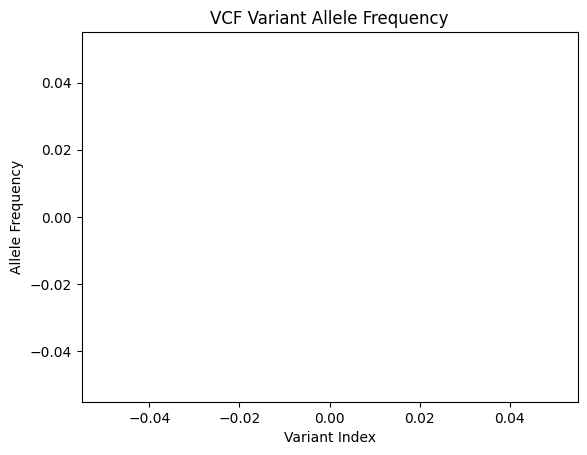

In [29]:
import pysam
import matplotlib.pyplot as plt

vcf_reader = pysam.VariantFile(open(output_vcf, "r"))

# Păstrați informațiile relevante pentru grafic (de exemplu, AF - frecvența alelei alternative)
allele_frequencies = []
for record in vcf_reader:
    allele_frequencies.append(record.INFO.get("AF")[0])

# Plasați graficul
plt.plot(allele_frequencies)
plt.xlabel("Variant Index")
plt.ylabel("Allele Frequency")
plt.title("VCF Variant Allele Frequency")
plt.show()